In [1]:
project_dir = "~/ben_lustre/current_projects/kidney_glomTI_response"
setwd(project_dir)
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
clean_theme <- theme_bw() + theme(axis.text = element_text(color = "black"), axis.title = element_text(color = "black"))
library(ggplot2)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
ad = import("anndata")
sc = import("scanpy")

In [3]:
make_jmat = function(reference, predictions, cell_names){
    unique_ref = unique(reference)
    unique_pred = unique(predictions)
    jmat = matrix(0, ncol = length(unique_ref), nrow = length(unique_pred))
    rownames(jmat) = unique_pred
    colnames(jmat) = unique_ref
    for(c in unique_ref){
        for(r in unique_pred){
            c_cells = cell_names[reference %in% c]
            r_cells = cell_names[predictions %in% r]
            jac = length(intersect(c_cells, r_cells))/length(union(c_cells, r_cells))
            jmat[r,c] =jac
        }
    }
return(jmat)  
}

In [16]:
#nuclei
nuclei_adata = sc$read_h5ad("./data/annotated/multiome_adata.h5ad")

In [17]:
#celltype predictions 
cell_type_predictions = read.csv("./data/knn_predictions/nuclei_celltype_predictions.csv", row.names = 1)
cell_type_jmat = make_jmat(reference = nuclei_adata$obs$cell_type, predictions = cell_type_predictions[, 1], cell_names = nuclei_adata$obs_names$values )
prediction_order = rownames(cell_type_jmat)[hclust(dist(cell_type_jmat), method = 'average')$order]
jmat_long = reshape2::melt(cell_type_jmat)
jmat_long$Var2 = factor(jmat_long$Var2, levels = rev(levels(nuclei_adata$obs$cell_type)))
jmat_long$Var1 = factor(jmat_long$Var1, levels = prediction_order)

png 
  2

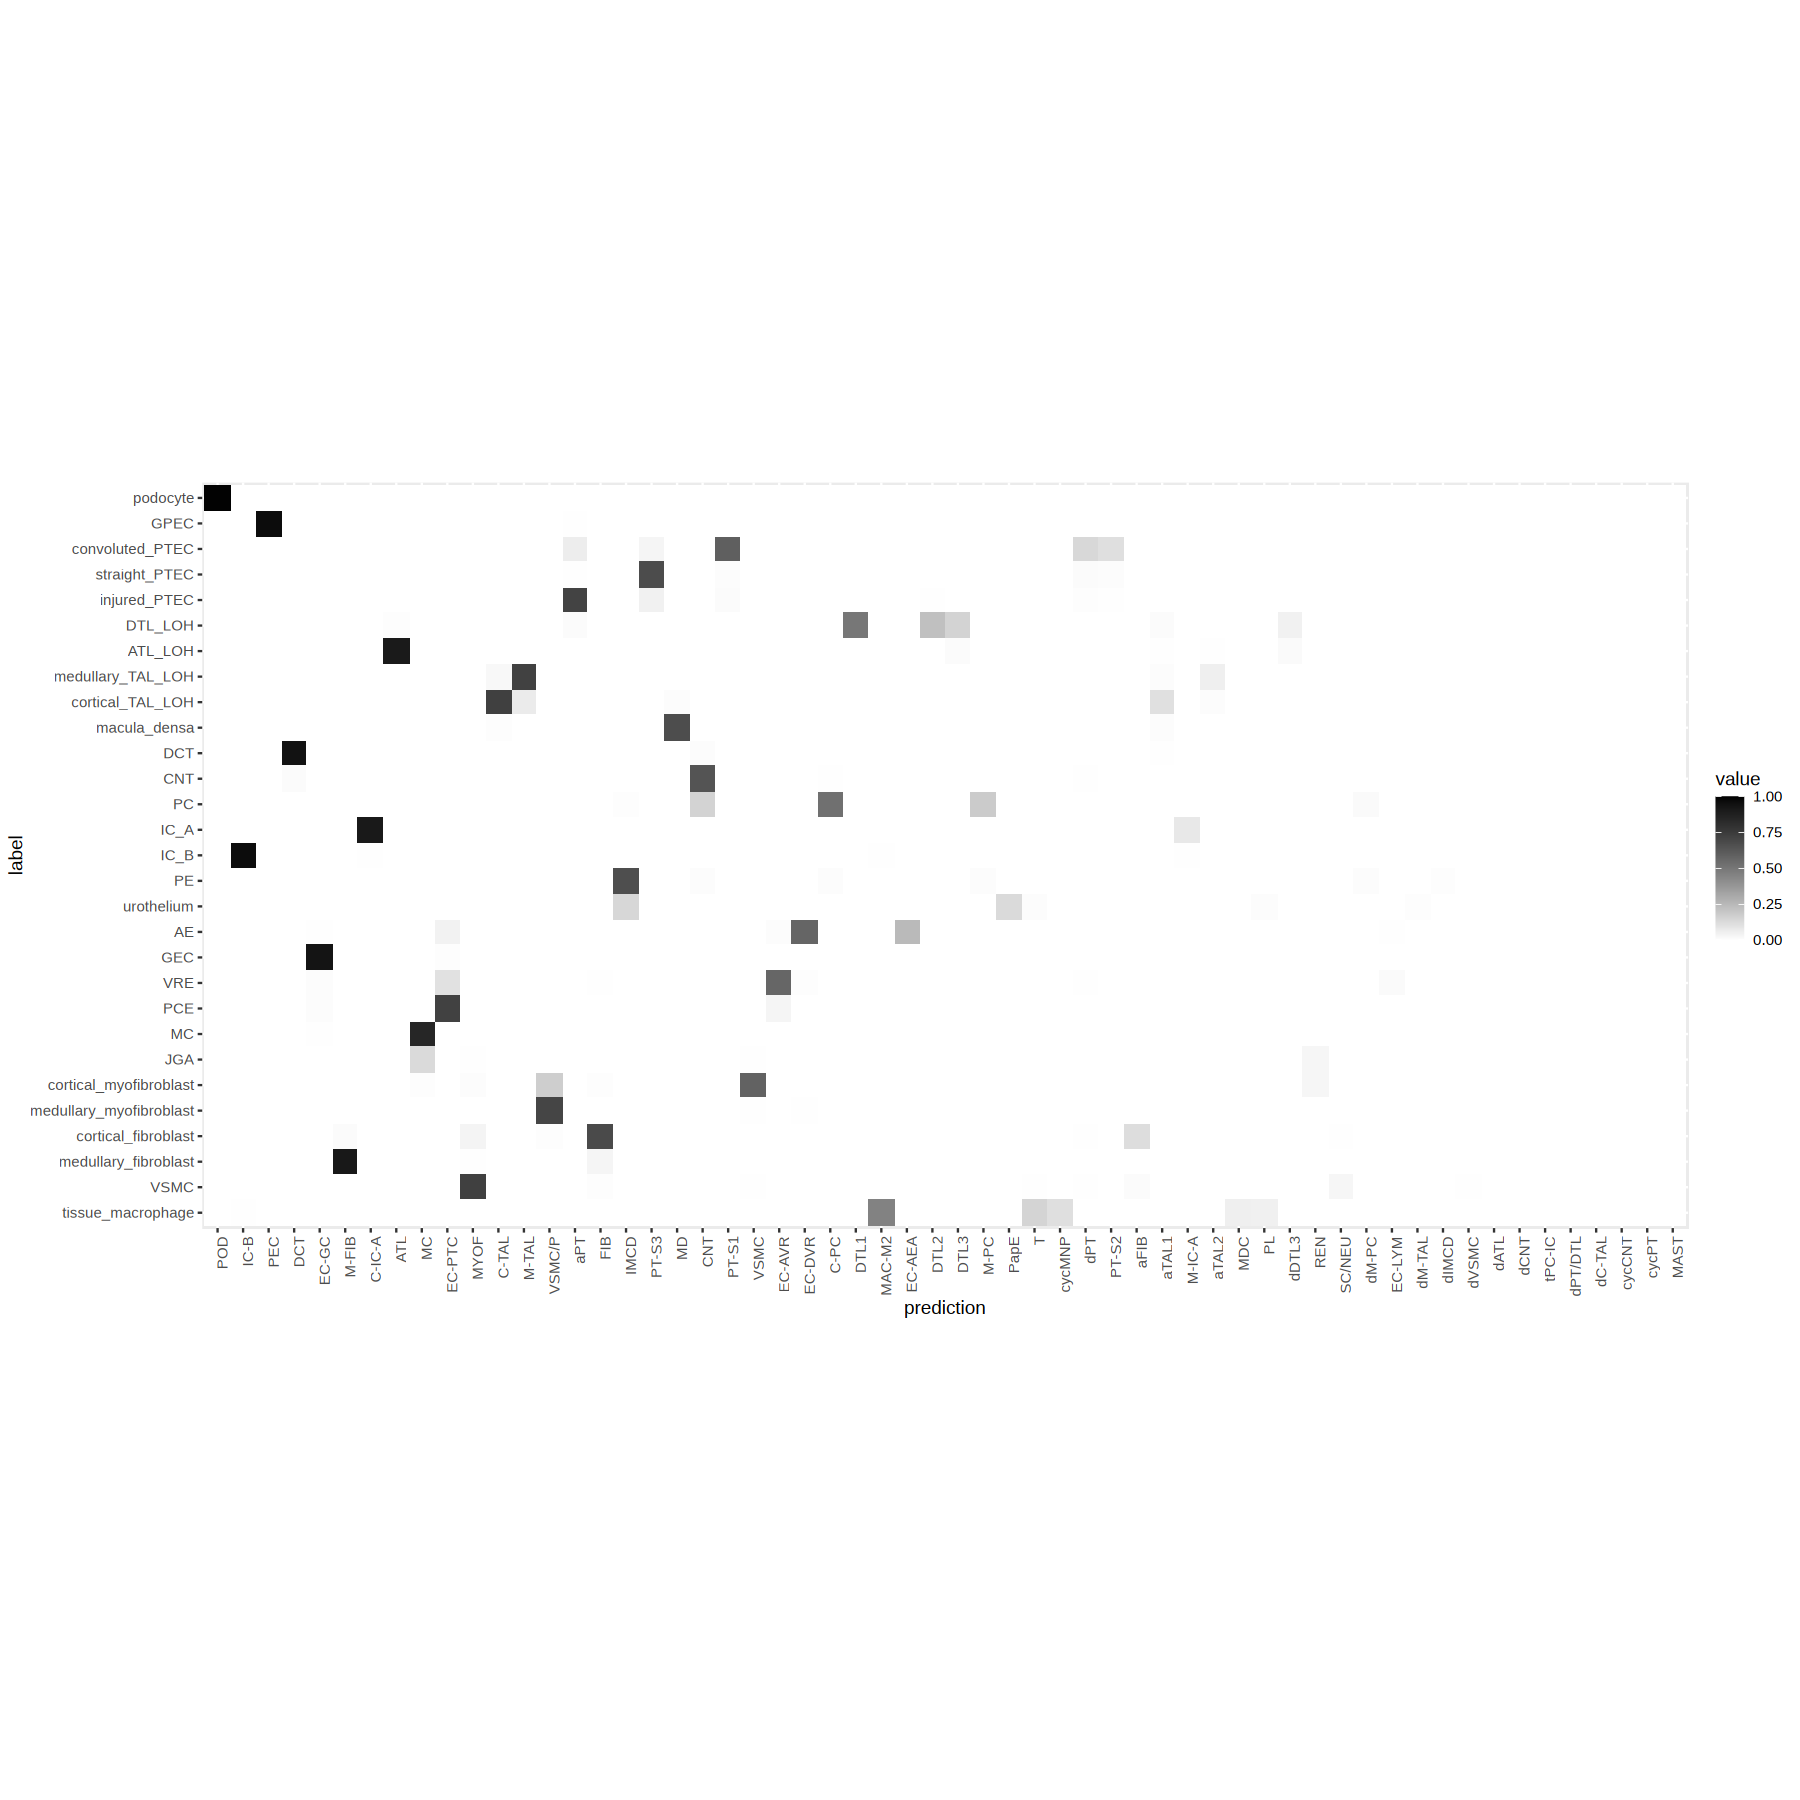

In [18]:
#plot
options(repr.plot.width = 15, repr.plot.height = 15)
cell_type_heatmap = ggplot(jmat_long, aes(x = Var1, y= Var2, fill = value)) + 
geom_tile() + coord_fixed() + scale_fill_gradientn(colors = c("white", "black"), limits = c(0,1)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + xlab('prediction') + ylab("label")
cell_type_heatmap
pdf("./figures/cell_type_heatmap.pdf", width = 15, height= 15)
cell_type_heatmap
dev.off()

In [68]:
#region predictions 
region_predictions = read.csv("./data/knn_predictions/nuclei_region_predictions.csv", row.names = 1)
region_df = data.frame(table(nuclei_adata$obs$cell_type, region_predictions$X0)/rowSums(table(nuclei_adata$obs$cell_type, region_predictions$X0)))

png 
  2

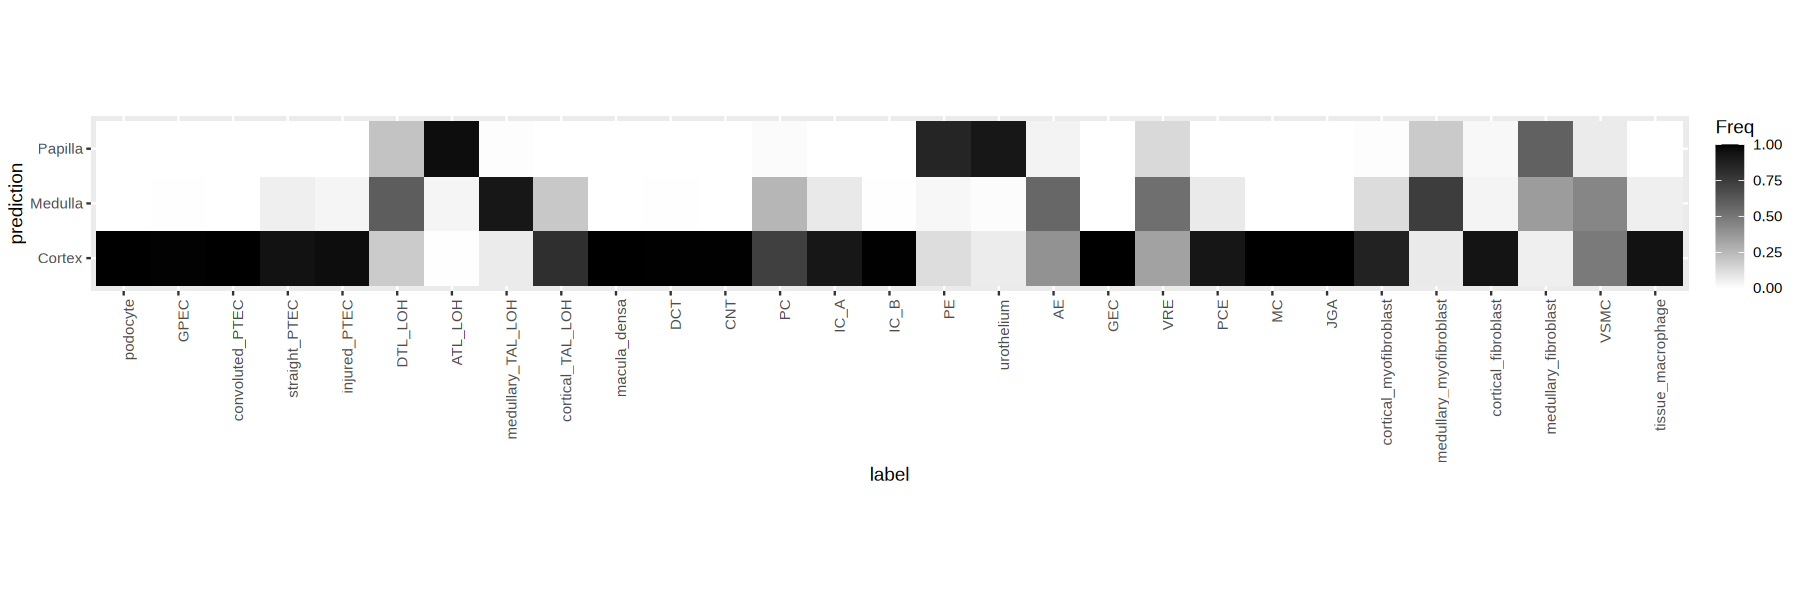

In [69]:
options(repr.plot.width = 15, repr.plot.height = 5)
depth_heatmap = ggplot(region_df, aes(x = Var1, y = Var2, fill = Freq)) + geom_tile() + coord_fixed() + scale_fill_gradientn(colors = c("white", "black"), limits = c(0,1)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + ylab('prediction') + xlab("label")
depth_heatmap
pdf("./figures/depth_heatmap.pdf", width = 15, height= 5)
depth_heatmap
dev.off()

png 
  2

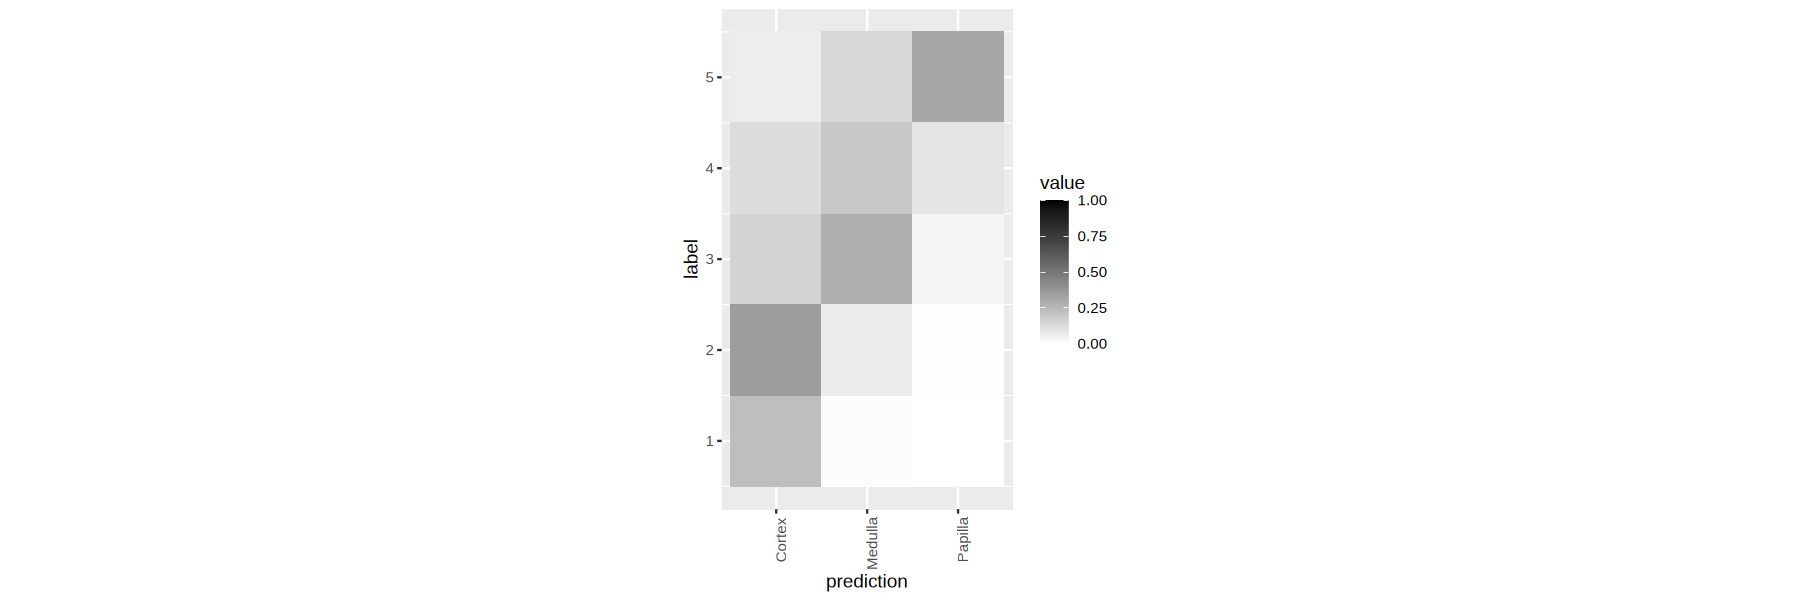

In [102]:
sampling_depths = nuclei_adata$obs['depth']
region_sampling_df = data.frame(sampling_depths, region_predictions)
region_sampling_df = region_sampling_df[!region_sampling_df$depth == 'kidney_cortex', ]
region_jmat = make_jmat(reference = region_sampling_df[, 1], predictions = region_sampling_df[, 2], cell_names = rownames(region_sampling_df) )
jmat_long = reshape2::melt(region_jmat)
region_heatmap = ggplot(jmat_long, aes(x = Var1, y= Var2, fill = value)) + 
geom_tile() + coord_fixed() + scale_fill_gradientn(colors = c("white", "black"), limits = c(0,1)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + xlab('prediction') + ylab("label")
pdf("./figures/nuclei_region_heatmap.pdf", width = 15, height= 15)
region_heatmap
dev.off()
region_heatmap

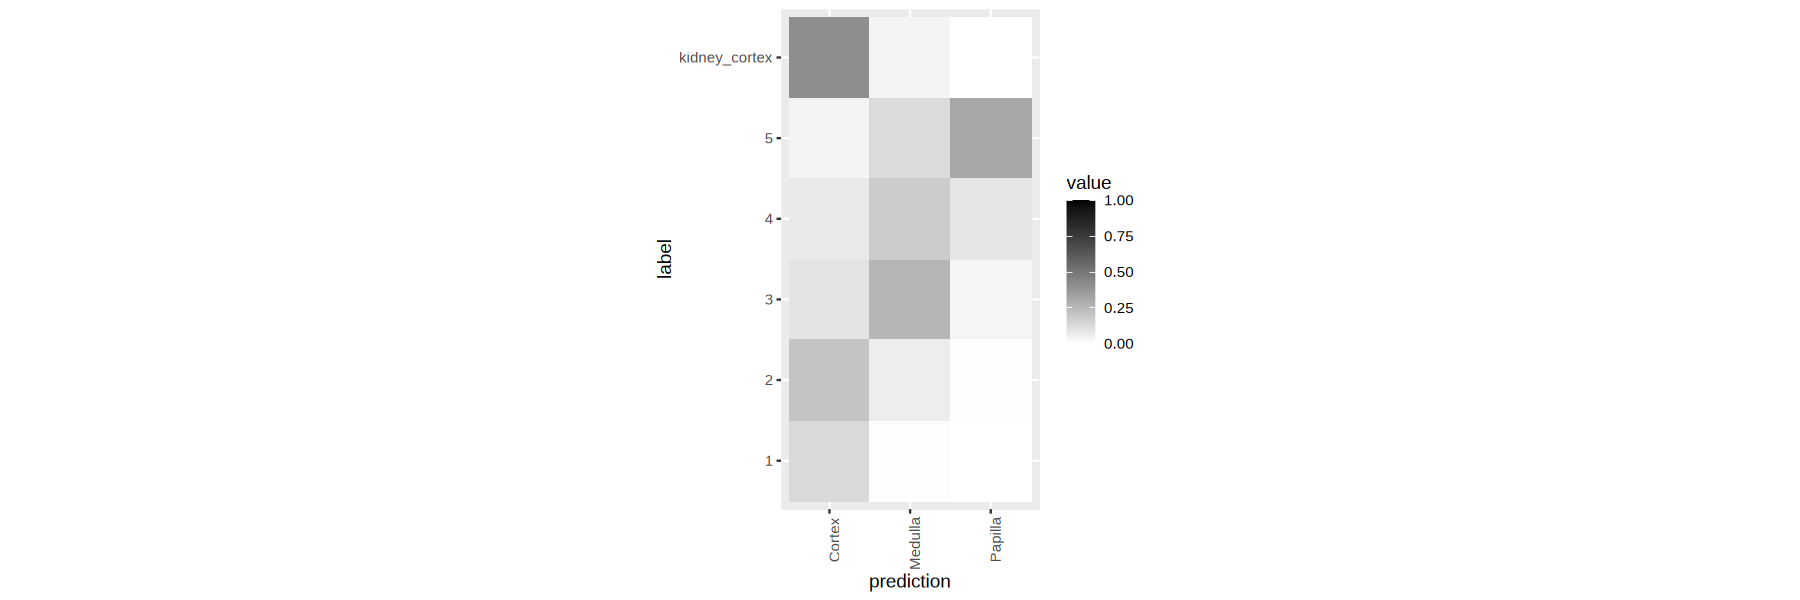

In [ ]:
#get depths 
depths = read.csv("./data/da_results/depth/multiome_depth.csv", row.names = 1)
region_predictions = read.csv("./data/knn_predictions/nuclei_region_predictions.csv", row.names = 1)
region_predictions$depth_score = 0
region_predictions = region_predictions[rownames(depths), ]
region_predictions$depth_score = depths$depth_score

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 7.5)
depth_boxplot = ggplot(region_predictions, aes(x = X0, group = X0,  y= depth_score)) + geom_boxplot(outlier.shape = NA) +  theme_minimal() + xlab("predictedj depth") + 
ylab("depth score")
depth_boxplot
pdf("./figures/depth_boxplot.pdf", width = 5, height =7.5)
depth_boxplot
dev.off()

In [ ]:
#state predictions 
state_predictions = read.csv("./data/knn_predictions/nuclei_state_predictions.csv", row.names = 1)
state_df = data.frame(table(nuclei_adata$obs$cell_type, state_predictions$X0)/rowSums(table(nuclei_adata$obs$cell_type, state_predictions$X0)))

In [ ]:
#plot
options(repr.plot.width = 15, repr.plot.height = 5)
state_heatmap = ggplot(state_df, aes(x = Var1, y = Var2, fill = Freq)) + geom_tile()  + coord_fixed() + scale_fill_gradientn(colors = c("white", "black"), limits = c(0,1)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + ylab('prediction') + xlab("label")
pdf("./figures/state_heatmap.pdf", width = 15, height = 5)
state_heatmap
dev.off()

In [ ]:
#state predictions 
structure_predictions = read.csv("./data/knn_predictions/nuclei_structure_predictions.csv", row.names = 1)
structure_df = data.frame(table(nuclei_adata$obs$cell_type, structure_predictions$X0)/rowSums(table(nuclei_adata$obs$cell_type, structure_predictions$X0)))

In [ ]:
#plot
options(repr.plot.width = 15, repr.plot.height = 5)
structure_heatmap = ggplot(structure_df, aes(x = Var1, y = Var2, fill = Freq)) + geom_tile()  + coord_fixed() + scale_fill_gradientn(colors = c("white", "black"), limits = c(0,1)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + ylab('prediction') + xlab("label")
structure_heatmap
pdf("./figures/structure_heatmap.pdf", width = 15, height = 5)
structure_heatmap
dev.off()

In [4]:
#cells
cell_adata = sc$read_h5ad("./data/annotated/scRNAseq_glom_TI_kidney.h5ad")

In [19]:
#celltype predictions 
cell_type_predictions = read.csv("./data/knn_predictions/cell_celltype_predictions.csv", row.names = 1)
cell_type_jmat = make_jmat(reference = cell_adata$obs$cell_type, predictions = cell_type_predictions[, 1], cell_names = cell_adata$obs_names$values )
prediction_order = rownames(cell_type_jmat)[hclust(dist(cell_type_jmat), method = 'ward.D2')$order]
jmat_long = reshape2::melt(cell_type_jmat)
jmat_long$Var2 = factor(jmat_long$Var2, levels = rev(levels(cell_adata$obs$cell_type)))
jmat_long$Var1 = factor(jmat_long$Var1, levels = prediction_order)

In [21]:
#plot
options(repr.plot.width = 15, repr.plot.height = 15)
cell_type_heatmap = ggplot(jmat_long, aes(x = Var1, y= Var2, fill = value)) + 
geom_tile() + coord_fixed() + scale_fill_gradientn(colors = c("white", "black"), limits = c(0,1)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + xlab('prediction') + ylab("label")
pdf("./figures/lake_cell_heatmap.pdf", width = 15, height = 15)
cell_type_heatmap
dev.off()

png 
  2

In [9]:
#state predictions 
state_predictions = read.csv("./data/knn_predictions/cell_state_predictions.csv", row.names = 1)
structure_df = data.frame(table(cell_adata$obs$cell_type, state_predictions$X0)/rowSums(table(cell_adata$obs$cell_type, state_predictions$X0)))

png 
  2

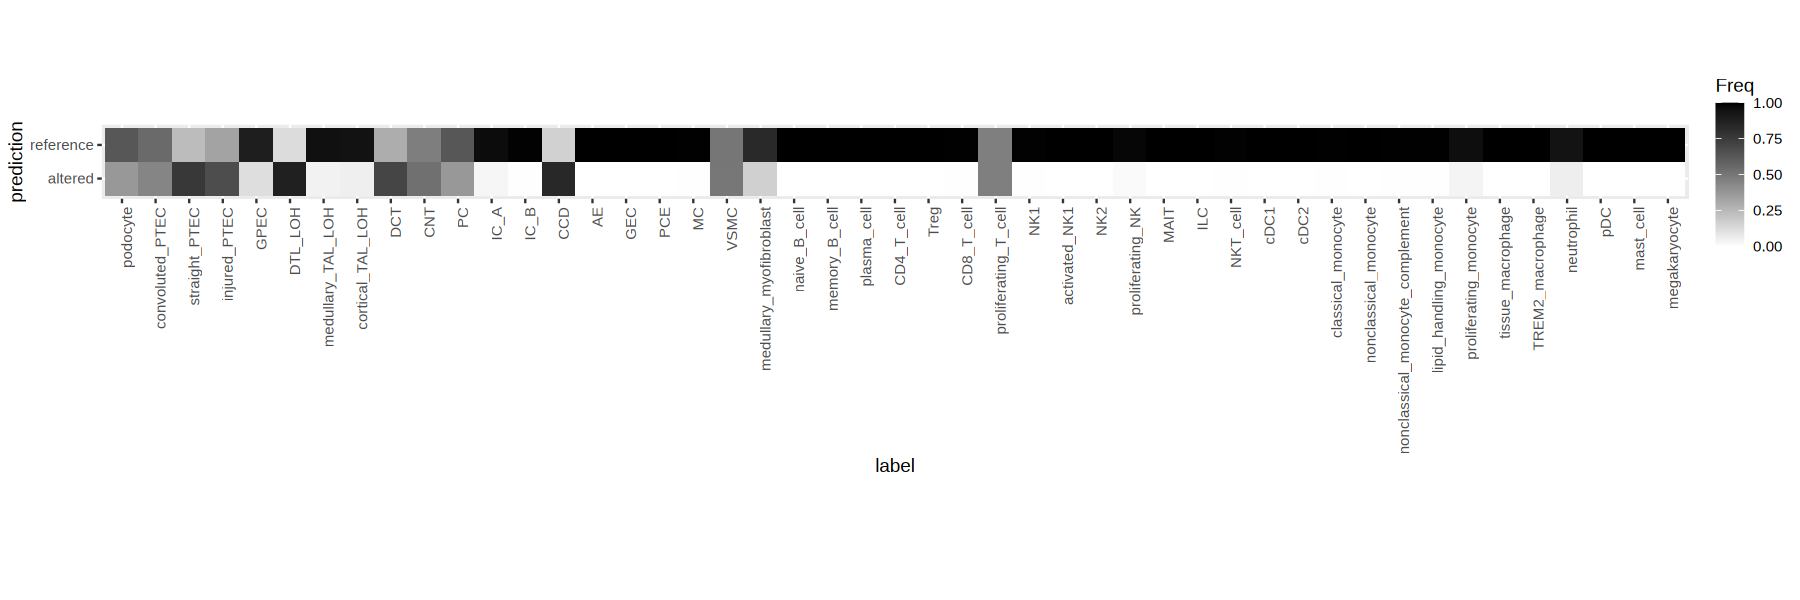

In [11]:
#plot
options(repr.plot.width = 15, repr.plot.height = 5)
state_heatmap = ggplot(structure_df, aes(x = Var1, y = Var2, fill = Freq)) + geom_tile()  + coord_fixed() + scale_fill_gradientn(colors = c("white", "black"), limits = c(0,1)) + 
theme(axis.text.x = element_text(angle = 90, hjust = 1)) + ylab('prediction') + xlab("label")
state_heatmap
pdf("./figures/cells_state_heatmap.pdf", width = 15, height = 5)
state_heatmap
dev.off()